# LSTM Sentiment Analysis With Emoji


#   

![JPEG](https://i.imgur.com/ooEYYMk.png)

#   

### LSTM을 이용해 이모티콘이 포함되어있는 텍스트를 감정분석 합니다
####   

![JPEG](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcT43Pq08L6GpfNPYCofclAVHutZQhLimdQQypmOtxtkGhn2CxPr)

#   

In [1]:
import json
import os
from pprint import pprint
from konlpy.tag import Okt
import nltk
import numpy as np
import pandas as pd
import time

In [2]:
def read_data(filename):
    with open(filename, 'r') as f:
        # tab 별로 자른다
        data = [line.split('\t') for line in f.read().splitlines()]
        # txt 파일의 헤더(id document label)는 제외하기
        data = data[1:]
    return data

train_data = read_data('ratings_train.txt')
test_data = read_data('ratings_test.txt')

okt = Okt()

In [3]:
def tokenize(doc):
    # 토큰과 근어 사이에 '/'로 구부해줍니다
    # norm은 정규화, stem은 근어로 표시하기를 나타냄
    return ['/'.join(t) for t in okt.pos(doc, norm=True, stem=True)]

# 매번 반복하지 않기 위해 json파일이 있으면 읽어서 사용
if os.path.isfile('train_docs.json'):
    with open('train_docs.json') as f:
        train_docs = json.load(f)
    with open('test_docs.json') as f:
        test_docs = json.load(f)
else:
    # row[1]에 리뷰가, row[2]에 부정or긍정이 담겨있음
    train_docs = [(tokenize(row[1]), row[2]) for row in train_data]
    test_docs = [(tokenize(row[1]), row[2]) for row in test_data]
    # JSON 파일로 저장
    with open('train_docs.json', 'w', encoding="utf-8") as make_file:
        json.dump(train_docs, make_file, ensure_ascii=False, indent="\t")
    with open('test_docs.json', 'w', encoding="utf-8") as make_file:
        json.dump(test_docs, make_file, ensure_ascii=False, indent="\t")

In [4]:
tokens = [t for d in train_docs for t in d[0]]

In [5]:
text = nltk.Text(tokens, name='NMSC')

# 전체 토큰의 개수
print('전체 토큰의 개수 : {}'.format(len(text.tokens)))

# 중복을 제외한 토큰의 개수
print('중복을 제외한 토큰의 개수 : {}'.format(len(set(text.tokens))))

전체 토큰의 개수 : 2159921
중복을 제외한 토큰의 개수 : 49895


In [6]:
# 모든 문장을 학습할 순 없으니 가장 많이 등장하는 2500개의 토큰을 사용해서 벡터화
# RAM이 높다면 10000까지 해봅시다
selected_words = [f[0] for f in text.vocab().most_common(3000)]

# selected_words 안에 있는 단어들이 doc안에 있는지 확인해서 반환
# 문서집합에서 단어 토큰을 생성하고 각 단어의 수를 세어 BOW 인코딩한 벡터를 만듭니다
# BOW(Back Of Words)
def term_frequency(doc):
    return [doc.count(word) for word in selected_words]

# token_list : 0 or 1(긍정,부정)으로 이루어져있으므로 token_list만 확인(d, _)
# train_docs 안에 있는 toekn중 selected_words에 들어있는 단어만 포함
# train_docs는 2차원 list들([[영화 리뷰], 긍정or부정])로 구성된 3차원 list
# train_x는 0과 1로 이루어진 5천개의 list가 15만개 존재(2차원 list)
train_x = [term_frequency(d) for d, _ in train_docs]
test_x = [term_frequency(d) for d, _ in test_docs]
train_y = [c for _, c in train_docs]
test_y = [c for _, c in test_docs]

In [7]:
# 데이터가 문자열이니 input을 위해 float으로 바꿔줍니다
# 15만개의 데이터가 각각 2500개의 0과 1로 존재

x_train = np.asarray(train_x).astype('float32')
x_test = np.asarray(test_x).astype('float32')

y_train = np.asarray(train_y).astype('float32')
y_test = np.asarray(test_y).astype('float32')

In [8]:
# LSTM은 3차원 리스트만 input으로 받으니 3차원으로 reshape 해줍니다
# [샘플 수, 타임스텝 수, 속성 수]로 구성됩니다
# 타임스텝이란 하나의 샘플에 포함된 시퀀스 개수(여기선 리뷰 글 하나)
# embedding 기능을 사용하면 자동으로 변환되지만 학습이 너무 느려져 직접 변환해줍니다

X_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
X_test = np.reshape(x_test, (x_test.shape[0], 1, x_train.shape[1]))

In [9]:
# LSTM모델을 이용해 감정도 예측
# EarlyStopping을 이용해 과적합이 발생하면 훈련을 바로 중단시킵니다

from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping
from keras.models import load_model

model = Sequential()
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# 과적합을 방지하기 위해 과적합이 진행되면 바로 EarlyStopping
early_stopping = EarlyStopping()

model.fit(X_train, y_train, validation_data=(X_test, y_test), 
          epochs=100, batch_size=25, callbacks=[early_stopping])

scores = model.evaluate(X_test, y_test, verbose=0)

print('\n')
print("정확도: %.2f%%" % (scores[1]*100))

model.save('Sentiment Analysis.h5')

Using TensorFlow backend.


Train on 150000 samples, validate on 50000 samples
Epoch 1/100
150000/150000 [==============================] - 53s 353us/step - loss: 0.3805 - acc: 0.8309 - val_loss: 0.3681 - val_acc: 0.8358
Epoch 2/100
150000/150000 [==============================] - 51s 343us/step - loss: 0.3326 - acc: 0.8509 - val_loss: 0.3523 - val_acc: 0.8425
Epoch 3/100
150000/150000 [==============================] - 51s 341us/step - loss: 0.2971 - acc: 0.8697 - val_loss: 0.3479 - val_acc: 0.8493
Epoch 4/100
150000/150000 [==============================] - 51s 339us/step - loss: 0.2552 - acc: 0.8907 - val_loss: 0.3594 - val_acc: 0.8522


정확도: 85.22%


# 문장에 포함된 이모티콘 감정도 분석
#    

In [10]:
# 문장에서 이모티콘 처리를 해줍니다
emoji = pd.read_csv('Emoji.csv')

# emoji 딕셔너리로 만들어서 {emoji : emoji_sentiment}로 만들기
emoji_list = emoji['Emoji'].tolist()
emoji_neg = emoji['Negative'].tolist()
emoji_pos = emoji['Positive'].tolist()

emoji.head(20)

,Emoji,Unicode codepoint,Occurrences,Position,Negative,Neutral,Positive,Unicode name,Unicode block
0,😂,0x1f602,14622,0.805101,3614,4163,6845,FACE WITH TEARS OF JOY,Emoticons
1,❤,0x2764,8050,0.746943,355,1334,6361,HEAVY BLACK HEART,Dingbats
2,♥,0x2665,7144,0.753806,252,1942,4950,BLACK HEART SUIT,Miscellaneous Symbols
3,😍,0x1f60d,6359,0.765292,329,1390,4640,SMILING FACE WITH HEART-SHAPED EYES,Emoticons
4,😭,0x1f62d,5526,0.803352,2412,1218,1896,LOUDLY CRYING FACE,Emoticons
5,😘,0x1f618,3648,0.854480,193,702,2753,FACE THROWING A KISS,Emoticons
6,😊,0x1f60a,3186,0.813302,189,754,2243,SMILING FACE WITH SMILING EYES,Emoticons
7,👌,0x1f44c,2925,0.805223,274,728,1923,OK HAND SIGN,Miscellaneous Symbols and Pictographs
8,💕,0x1f495,2400,0.765726,99,683,1618,TWO HEARTS,Miscellaneous Symbols and Pictographs
9,👏,0x1f44f,2336,0.787130,243,634,1459,CLAPPING HANDS SIGN,Miscellaneous Symbols and Pictographs


In [11]:
# 이모티콘 딕셔너리를 만들어 {이모티콘 : 감정도} 형식으로 짝을 맞춰줍니다
emoji_dictionary = {}

for i in range(len(emoji_list)):
    
    # 이모티콘 긍정이 부정보다 높으면 양수
    if(emoji_pos[i]-emoji_neg[i]>0):
        emoji_sentiment = emoji_pos[i]- emoji_neg[i]
    # 이모티콘 부정이 긍정보다 높으면 음수
    else:
        emoji_sentiment = emoji_pos[i]- emoji_neg[i]
    
    # 각각 scale이 다르므로 소수점자리를 맞춰줍니다
    if(abs(emoji_sentiment)>=1000):
        emoji_sentiment/=1000000
    elif(abs(emoji_sentiment)>=100):
        emoji_sentiment/=100000
    elif(abs(emoji_sentiment)>=10):
        emoji_sentiment/=10000
    else:
        emoji_sentiment/=1000
    
    # 딕셔너리에 {이모티콘 : 감정도}로 추가
    emoji_dictionary[emoji_list[i]] = emoji_sentiment

In [12]:
loop_count = 0

for i, j in emoji_dictionary.items():
    print('이모티콘  {}의  감정도는 {}'.format(i,j))
    loop_count+=1
    
    if(loop_count > 50):
        break

이모티콘  😂의  감정도는 0.003231
이모티콘  ❤의  감정도는 0.006006
이모티콘  ♥의  감정도는 0.004698
이모티콘  😍의  감정도는 0.004311
이모티콘  😭의  감정도는 -0.00516
이모티콘  😘의  감정도는 0.00256
이모티콘  😊의  감정도는 0.002054
이모티콘  👌의  감정도는 0.001649
이모티콘  💕의  감정도는 0.001519
이모티콘  👏의  감정도는 0.001216
이모티콘  😁의  감정도는 0.00985
이모티콘  ☺의  감정도는 0.001357
이모티콘  ♡의  감정도는 0.001323
이모티콘  👍의  감정도는 0.00968
이모티콘  😩의  감정도는 -0.00666
이모티콘  🙏의  감정도는 0.00643
이모티콘  ✌의  감정도는 0.00712
이모티콘  😏의  감정도는 0.00506
이모티콘  😉의  감정도는 0.00706
이모티콘  🙌의  감정도는 0.00844
이모티콘  🙈의  감정도는 0.0063
이모티콘  💪의  감정도는 0.00783
이모티콘  😄의  감정도는 0.0059
이모티콘  😒의  감정도는 -0.00519
이모티콘  💃의  감정도는 0.00989
이모티콘  💖의  감정도는 0.00901
이모티콘  😃의  감정도는 0.00673
이모티콘  😔의  감정도는 -0.00176
이모티콘  😱의  감정도는 0.00215
이모티콘  🎉의  감정도는 0.00832
이모티콘  😜의  감정도는 0.00472
이모티콘  ☯의  감정도는 0.001
이모티콘  🌸의  감정도는 0.00617
이모티콘  💜의  감정도는 0.00616
이모티콘  💙의  감정도는 0.00668
이모티콘  ✨의  감정도는 0.00299
이모티콘  😳의  감정도는 0.0015
이모티콘  💗의  감정도는 0.00551
이모티콘  ★의  감정도는 0.00235
이모티콘  █의  감정도는 -0.0026
이모티콘  ☀의  감정도는 0.00367
이모티콘  😡의  감정도는 -0.00131
이모티콘  😎의  감정도는 0.00372
이

In [13]:
import pandas as pd
import numpy as np
from keras.models import load_model

def predict_sentiment_with_emoji(word):
    
    try:

        # 문장을 token화 시키고
        token = tokenize(word)
        # 가장많이 등장하는 단어와 토큰과 비교를하고
        tf = term_frequency(token)
        # 문장을 float형식으로 바꿔줍니다
        data = np.expand_dims(np.asarray(tf).astype('float32'), axis=0)
        # LSTM에 맞게 3차원 배열로 바꿔줍니다
        data = np.reshape(data, (data.shape[0], 1, data.shape[1]))
        # 예전에 학습한 LSTM모델을 불러옵니다
        score = float(model.predict(data))
    
        # 문장에 이모티콘이 포함되어 있으면 이모티콘의 sentiment만큼 가중치를 줍니다
        for emoji in emoji_dictionary:
            if emoji in word:
                score += emoji_dictionary[emoji]
        
        # 소수 5자리까지만 반환
        return round(score, 5)
    
    except:
        
        return 0.5

In [14]:
# DataFrame이 총 4개 (다음뉴스, 인스타, 트위터, 유튜브)
# Keyword 별로 통합 
# Title, Contents, Comments 각각 감정분석

In [15]:
insta_20190307 = pd.read_csv('20190307 instagram_dataframe')
daum_20190307 = pd.read_csv('20190307 daum_news_dataframe')
twitter_20190307 = pd.read_csv('20190307 tweet_dataframe')
youtube_20190307 = pd.read_csv('20190307 youtube_dataframe')

In [16]:
# 빈 dataframe을 만들어줘서 차곡차곡 넣는다

today_dataframe = pd.DataFrame(columns=['Topic', 'Keyword', 'Company', 'Title', 'Contents', 'Comments', 'KC', 'KCC'])

In [17]:
# daum, youtube, insta, twitter 순으로 넣어준다

index = 0

for i in range(80):
    today_dataframe.loc[index] = daum_20190307.loc[i]
    index += 1
    today_dataframe.loc[index] = youtube_20190307.loc[i]
    index += 1
    today_dataframe.loc[index] = insta_20190307.loc[i]
    index += 1
    today_dataframe.loc[index] = twitter_20190307.loc[i]
    index += 1
    

In [18]:
# Keyword Total Ratio 추가
# Total KTR, Topic KTR 따로

Total_KTR_list = []
Topic_KTR_list = []
Topic_KTR_dataframe = []
KTR_list = []
total_count_list = []
Topic_mean_list = []

total_count = 0

# Total KTR을 구하기 위해 평균을 구한다

for i in range(0,320,4):
    count = 0
    for j in range(4):
        count += today_dataframe.iloc[i+j]['KC']
        count += today_dataframe.iloc[i+j]['KCC']
    total_count_list.append(count)
    total_count+= count
    
mean_ratio = total_count/80

# 평균대비 Keyword Total Ratio

for i in range(80):
    total_KTR = round((total_count_list[i]/mean_ratio),2)
    Total_KTR_list.append(str(int(total_KTR * 100))+'%')
    for j in range(4):
        KTR = round((total_count_list[i]/mean_ratio),2)
        KTR_list.append(str(int(KTR * 100))+'%')

# Topic별로 KTR을 구하기 위해 Topic별로 평균을 구한다

for i in range(8):
    count=0
    for j in range(10):
        count+=total_count_list[10*i+j]
        
    Topic_mean_list.append(count/10)

    
for i in range(8):
    for j in range(10):
        topic_ktr = total_count_list[10*i+j] / Topic_mean_list[i]
        Topic_KTR_list.append(topic_ktr)
        Topic_KTR_dataframe.append(str(int(topic_ktr * 100))+'%')
    
        
today_dataframe['KTR'] = KTR_list

In [19]:
# Keyword Total Sentiment 추가

sentiment_list = []
dataframe_sentiment_list = []
start_time = time.time()

for i in range(320):
    
    title = str(today_dataframe.iloc[i]['Title'])
    content = str(today_dataframe.iloc[i]['Contents'])
    comment = str(today_dataframe.iloc[i]['Comments'])
    
    title_content_sentiment = predict_sentiment_with_emoji(title+content)
    comment_sentiment = predict_sentiment_with_emoji(comment)
    sentiment = round((title_content_sentiment + comment_sentiment)/2,2)
    sentiment_list.append(sentiment)
    dataframe_sentiment_list.append(str(int(sentiment * 100))+'%')

today_dataframe['Sentiment'] = dataframe_sentiment_list

print("걸린시간 : {}분".format(round((time.time() - start_time)/60, 1)))

걸린시간 : 15.1분


In [29]:
# Keyword Total Sentiment
# Daum News 50%, Youtube 35%, Instagram 5%, Twitter 15%의 가중치 

today_dataframe_KTS = []
Total_KTS_list = []

for i in range(0,320,4):
    KTS = 0
    for j in range(4):
        if(j % 4==0):
            KTS += 0.5 * sentiment_list[i+j]
        elif(j % 4==1):
            KTS += 0.35 * sentiment_list[i+j]
        elif(j % 4==2):
            KTS += 0.05 * sentiment_list[i+j]
        else:
            KTS += 0.15 * sentiment_list[i+j]
    
    Total_KTS_list.append(str(int(KTS * 100))+'%')
    
    for i in range(4):
        today_dataframe_KTS.append(str(int(KTS * 100))+'%')
    
today_dataframe['KTS'] = today_dataframe_KTS

In [32]:
# today_KTR_KTS dataframe

topic_list = daum_20190307['Topic'].values.tolist()
keyword_list = daum_20190307['Keyword'].values.tolist()

today_KTR_KTS = pd.DataFrame({'Topic':topic_list,
                              'Keyword':keyword_list,
                              'Total_KTR':Total_KTR_list,
                              'Topic_KTR':Topic_KTR_dataframe,
                              'KTS':Total_KTS_list})

In [33]:
today_KTR_KTS

,Topic,Keyword,Total_KTR,Topic_KTR,KTS
0,society,미세먼지,338%,282%,9%
1,society,이명박,72%,60%,5%
2,society,대통령,133%,110%,10%
3,society,보석,72%,59%,18%
4,society,마스크,108%,90%,34%
5,society,MB,164%,136%,27%
6,society,만에,111%,92%,34%
7,society,석방,73%,61%,9%
8,society,조건부,66%,55%,9%
9,society,민주노총,60%,50%,28%


In [34]:
# 어제와 오늘 중복된 Keyword가 있으면 변화량을 측정하기 위해
# 어제의 csv파일을 불러온다

yesterday_dataframe = pd.read_csv('yesterday')

In [35]:
compare_Total_KTR_list = ['New' for _ in range(80)]
compare_Topic_KTR_list = ['New' for _ in range(80)]
compare_KTS_list = ['New' for _ in range(80)]
 
for i in range(8):
    
    for j in range(10):
        
        keyword = today_KTR_KTS.iloc[10*i+j]['Keyword']
        
        for k in range(10):
            
            if keyword == yesterday_dataframe.iloc[10*i+k]['Keyword']:
                
                Total_KTR_change = int(today_KTR_KTS.iloc[10*i+j]['Total_KTR'][:-1]) - int(yesterday_dataframe.iloc[10*i+k]['Total_KTR'][:-1])
                compare_Total_KTR_list[10*i+j] = str(Total_KTR_change)+'%'
                
                Topic_KTR_change = int(today_KTR_KTS.iloc[10*i+j]['Topic_KTR'][:-1]) - int(yesterday_dataframe.iloc[10*i+k]['Topic_KTR'][:-1])
                compare_Topic_KTR_list[10*i+j] = str(Topic_KTR_change)+'%'
                
                KTS_change = int(today_KTR_KTS.iloc[10*i+j]['KTS'][:-1]) - int(yesterday_dataframe.iloc[10*i+k]['KTS'][:-1])
                compare_KTS_list[10*i+j] = str(KTS_change)+'%'

                
today_KTR_KTS['Total_KTR_change'] = compare_Total_KTR_list
today_KTR_KTS['Topic_KTR_change'] = compare_Topic_KTR_list
today_KTR_KTS['KTS_change'] = compare_KTS_list

In [36]:
today_KTR_KTS

,Topic,Keyword,Total_KTR,Topic_KTR,KTS,Total_KTR_change,Topic_KTR_change,KTS_change
0,society,미세먼지,338%,282%,9%,192%,230%,-19%
1,society,이명박,72%,60%,5%,New,New,New
2,society,대통령,133%,110%,10%,New,New,New
3,society,보석,72%,59%,18%,New,New,New
4,society,마스크,108%,90%,34%,New,New,New
5,society,MB,164%,136%,27%,New,New,New
6,society,만에,111%,92%,34%,New,New,New
7,society,석방,73%,61%,9%,New,New,New
8,society,조건부,66%,55%,9%,New,New,New
9,society,민주노총,60%,50%,28%,New,New,New


In [37]:
# top5 topic

keyword_list = today_KTR_KTS['Keyword'].values.tolist()
top5_topic = []

# pytrend는 keyword를 str이 아니라 list로 받으므로
# top5 topic을 모두 2차원 list로 설정

for i in range(8):
    for j in range(5):
        top5_topic.append([keyword_list[10*i+j]])

In [38]:
# top5 topic의 연관검색어 추출
from pytrends.request import TrendReq

top5_related_keyword = []
top5_related_value = []

pytrends = TrendReq(hl='ko')

for i in range(len(top5_topic)):
    
    # 시간설정은 지난 하루동안, 지역은 한국설정
    # 'rising'부분이 급상승 키워드 부분입니다(가중치도 함께 출력)
    
    try:
        pytrends.build_payload(top5_topic[i], geo = 'KR', timeframe='now 1-d')
        queries = pytrends.related_queries()
        dataframe = queries[top5_topic[i][0]]['rising']
   
        top5_related_keyword.append(dataframe['query'].values.tolist())
        top5_related_value.append(dataframe['value'].values.tolist())
    
    except:
        top5_related_keyword.append([])
        top5_related_value.append([])

미세먼지 연관 키워드


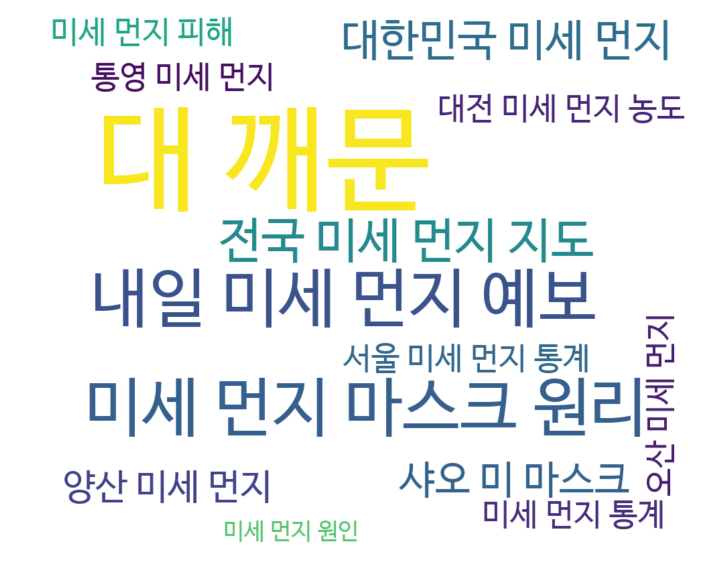

이명박 연관 키워드


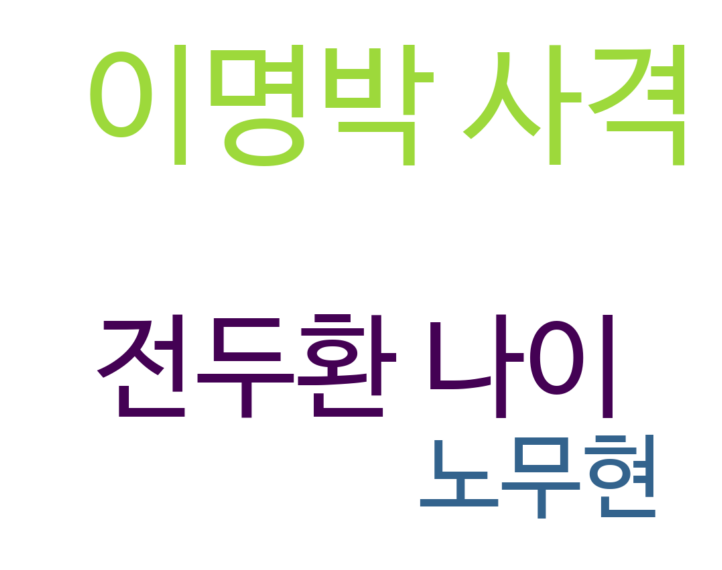

대통령 연관 키워드


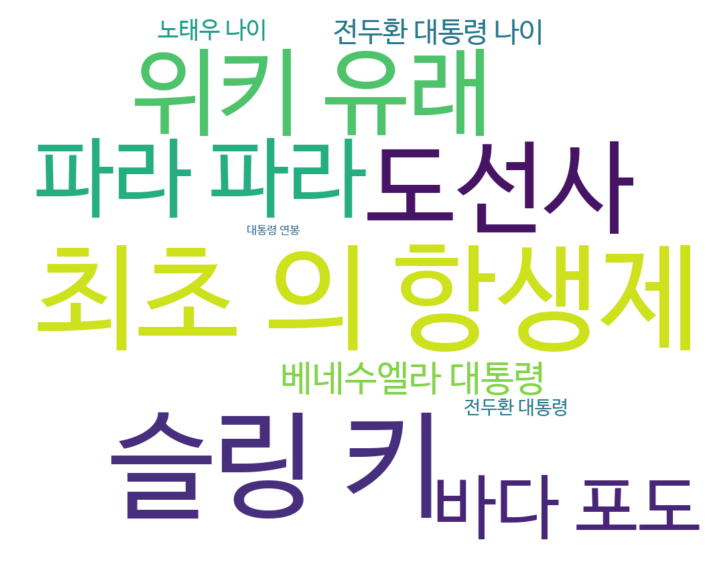

보석 연관 키워드


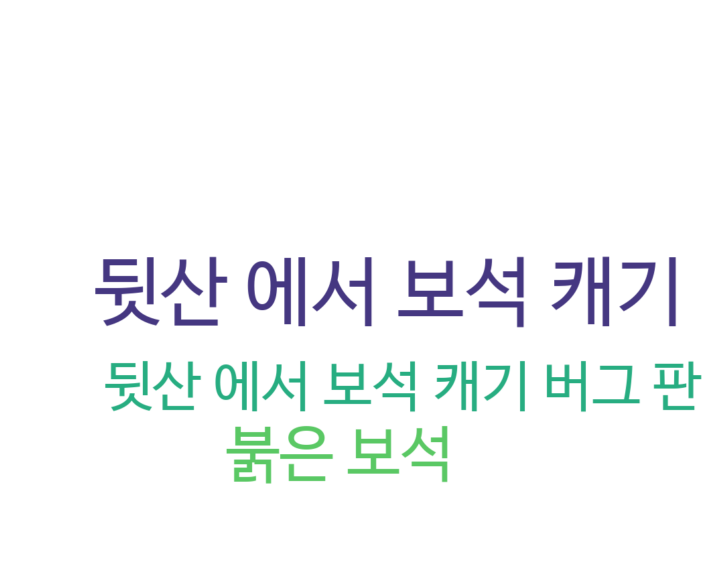

마스크 연관 키워드


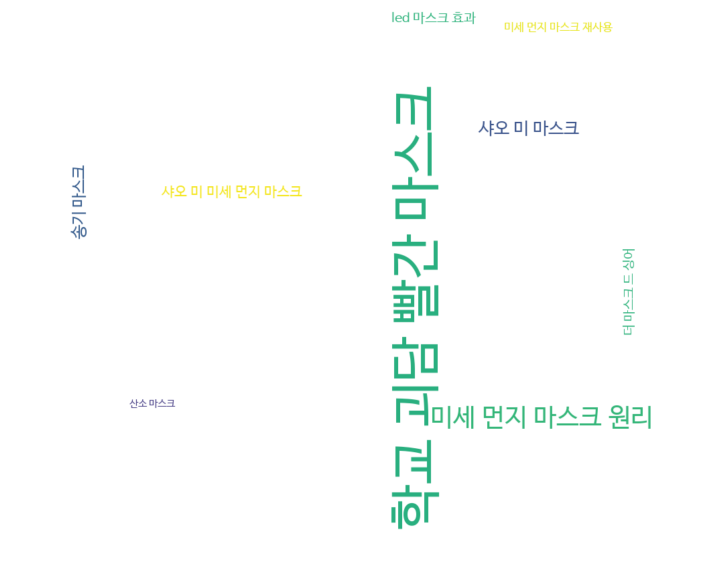

미세먼지 연관 키워드


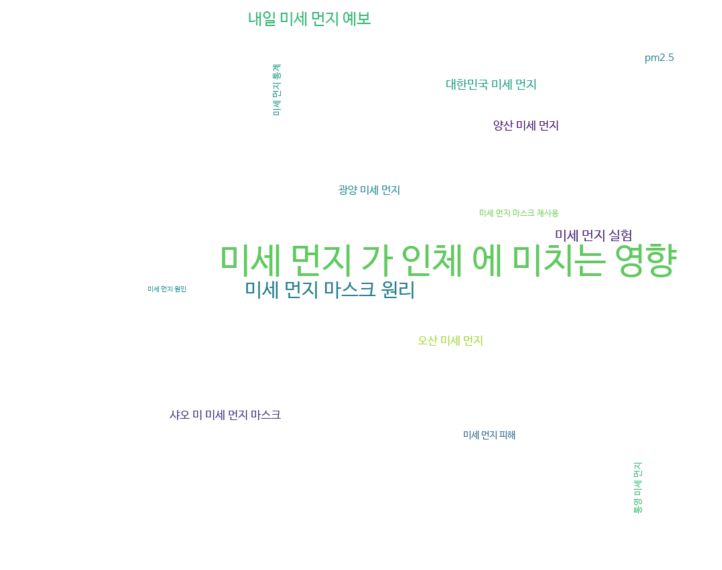

국회 연관 키워드


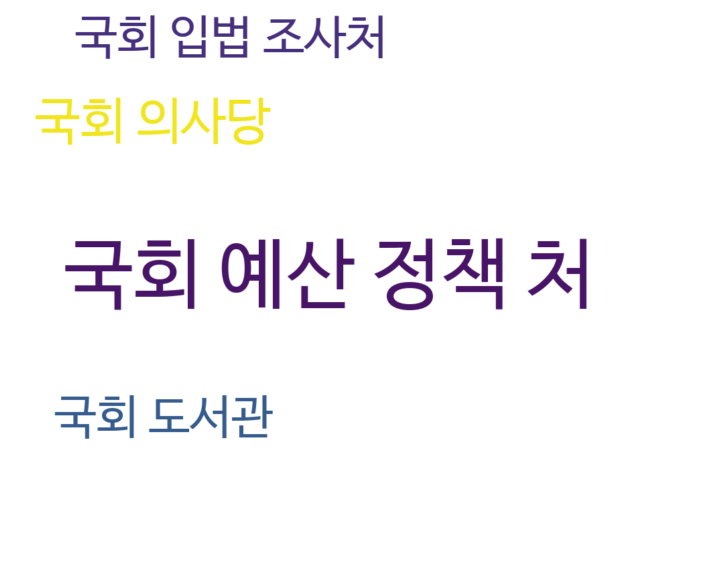

황교안 연관 키워드


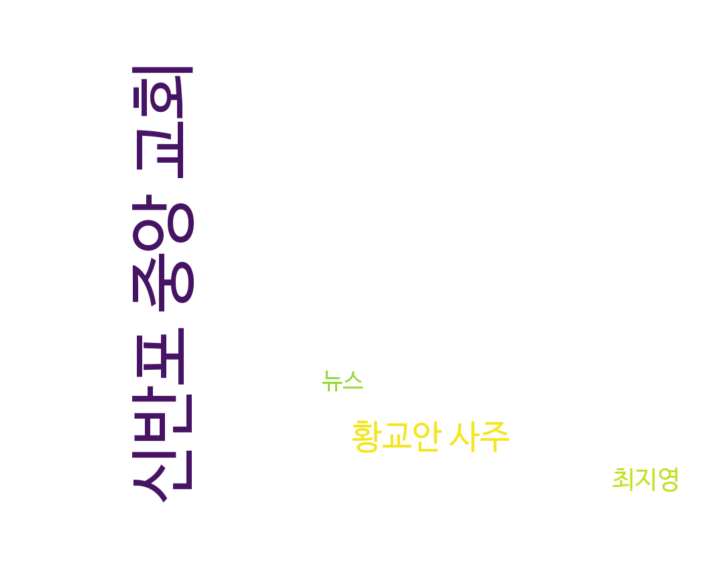

의원 연관 키워드


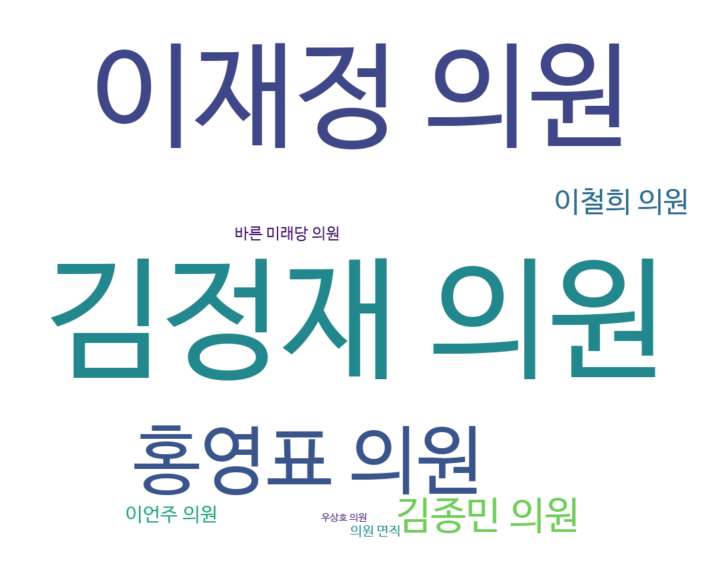

미세먼지 연관 키워드


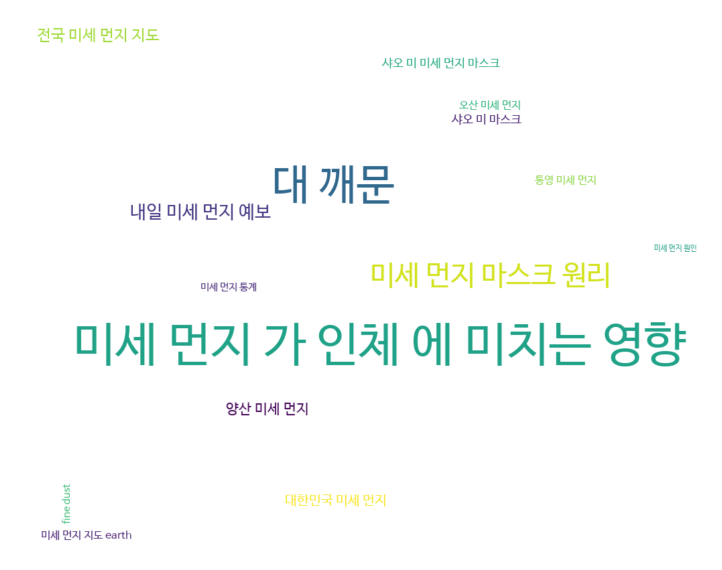

대통령 연관 키워드


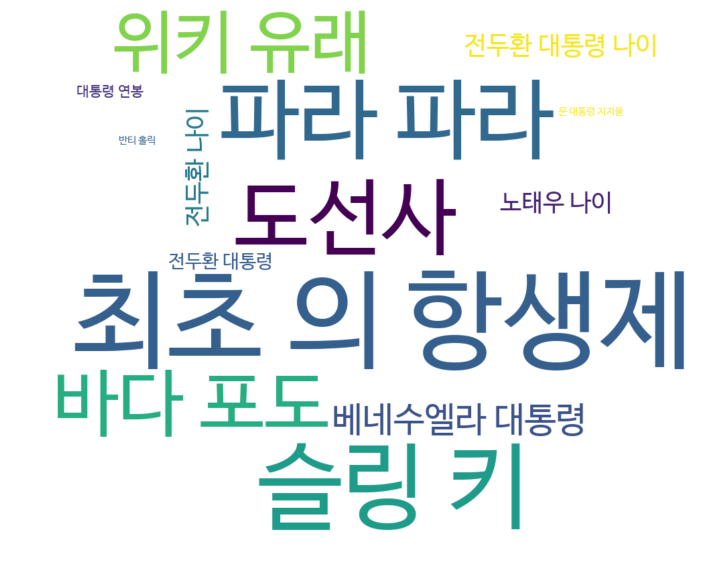

벤처 연관 키워드


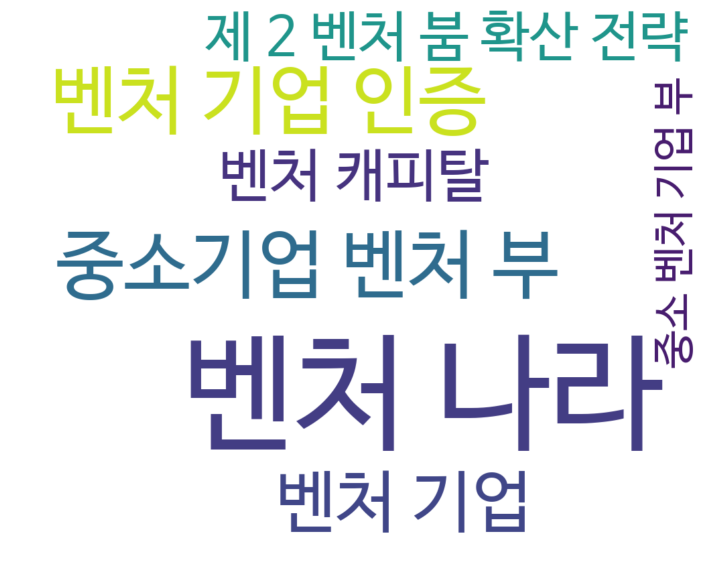

트럼프 연관 키워드


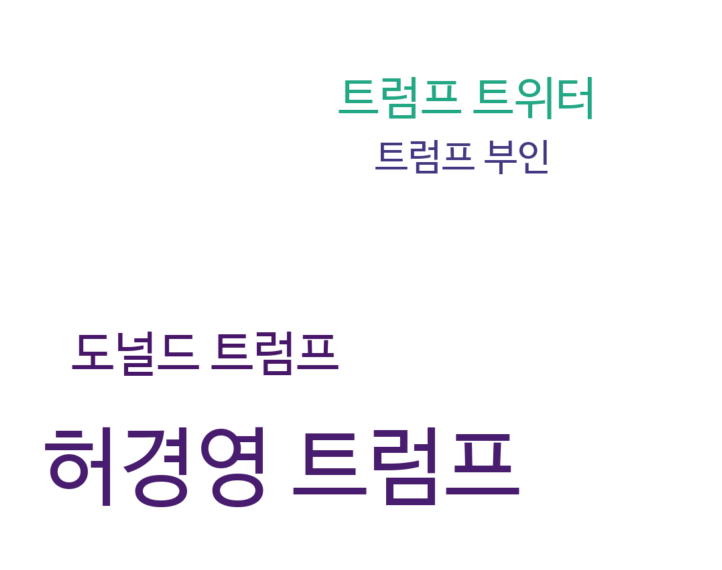

복구 연관 키워드


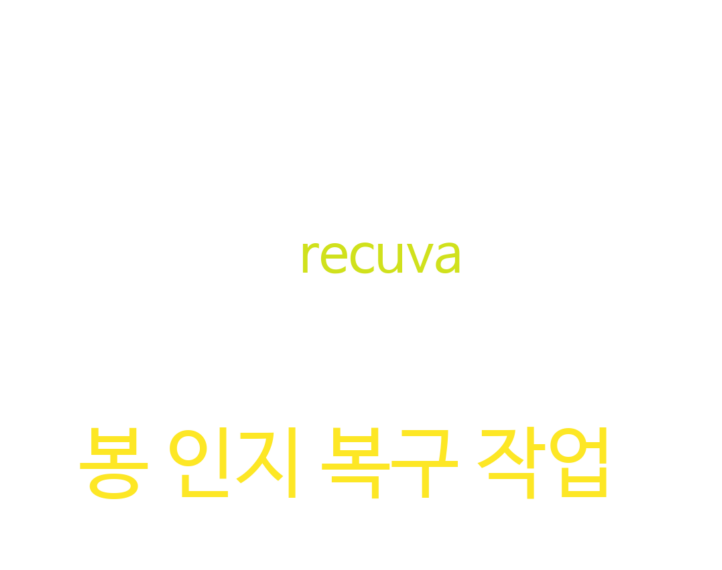

미사일 연관 키워드


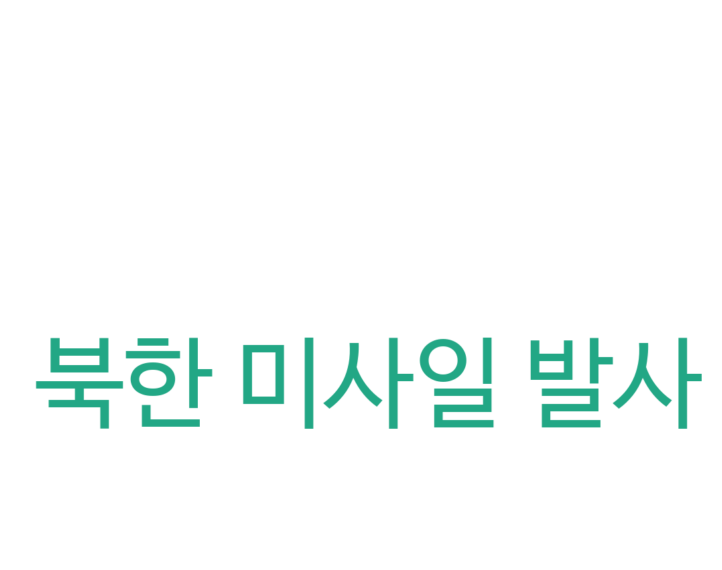

미세먼지 연관 키워드


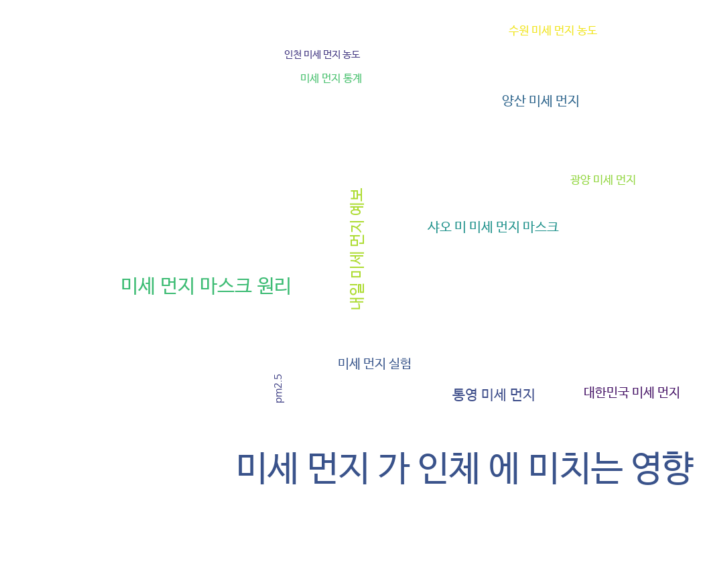

마스크 연관 키워드


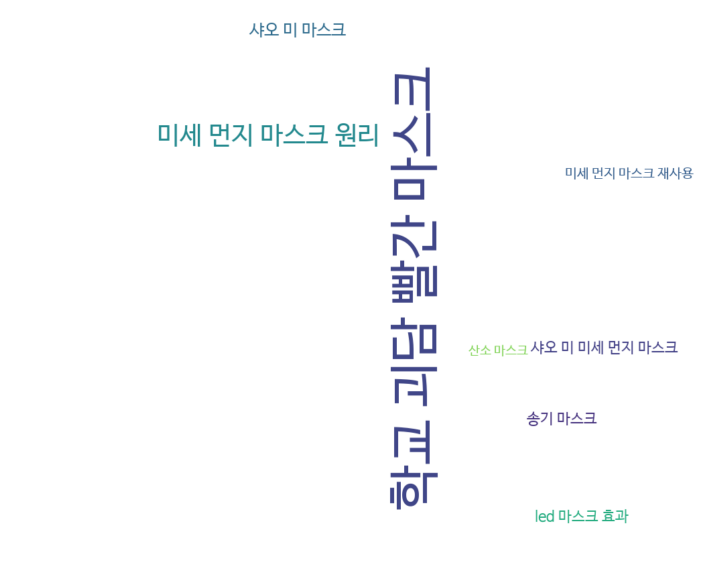

있지 연관 키워드


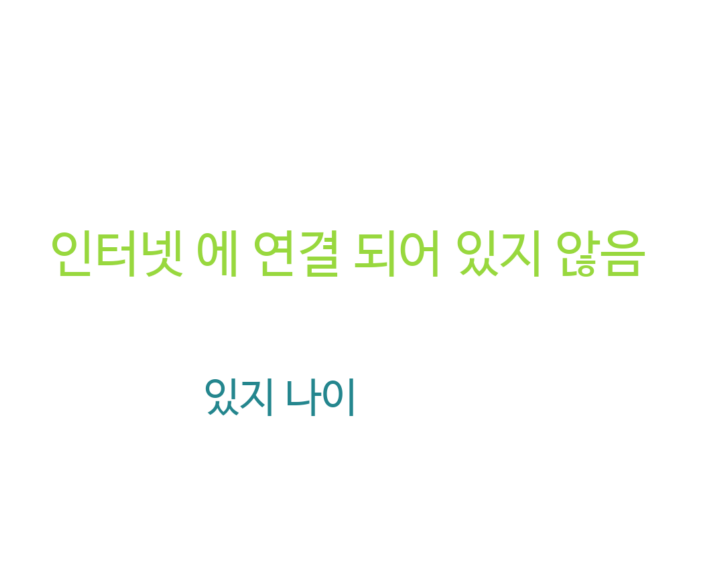

감독 연관 키워드


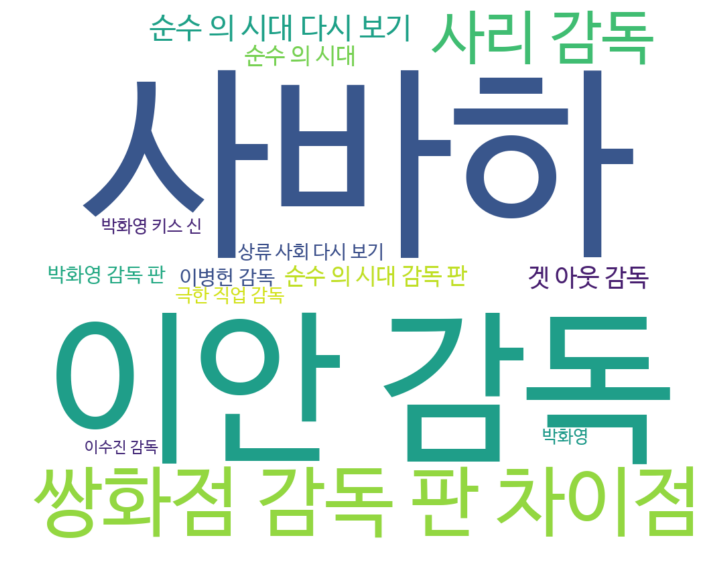

우승 연관 키워드


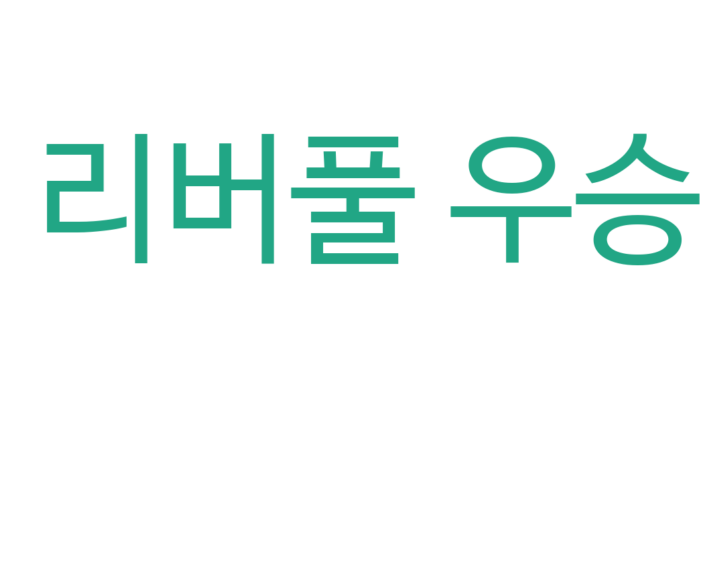

레알 연관 키워드


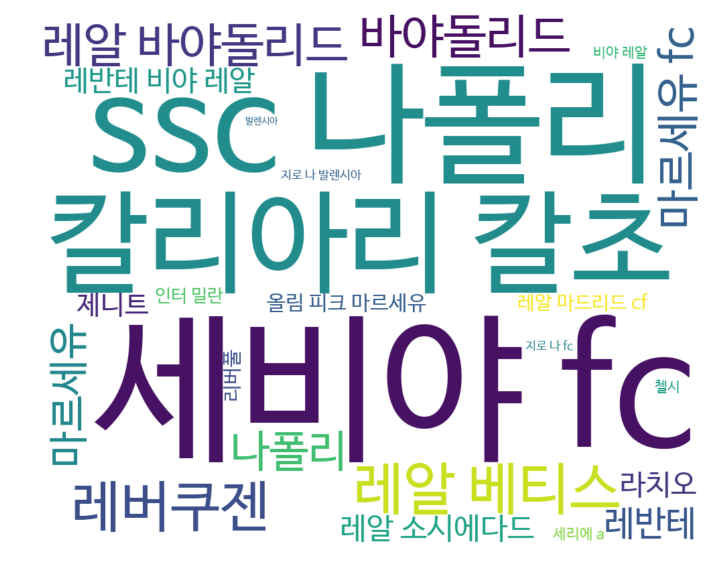

5G 연관 키워드


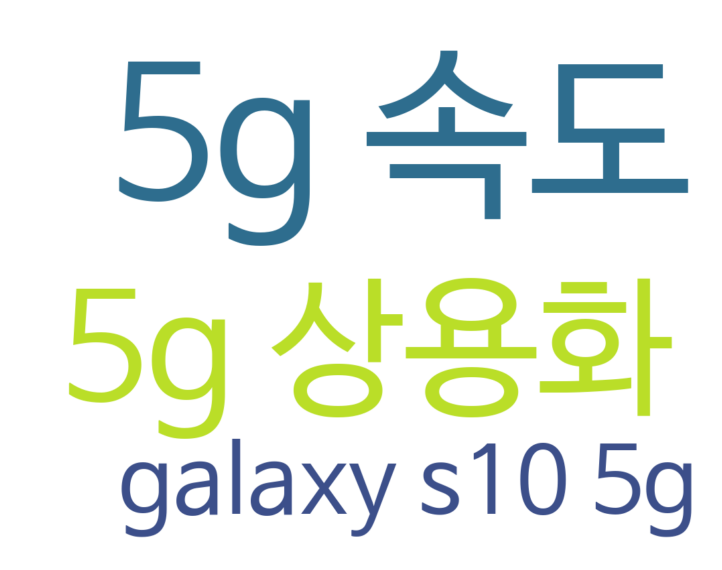

G8 연관 키워드


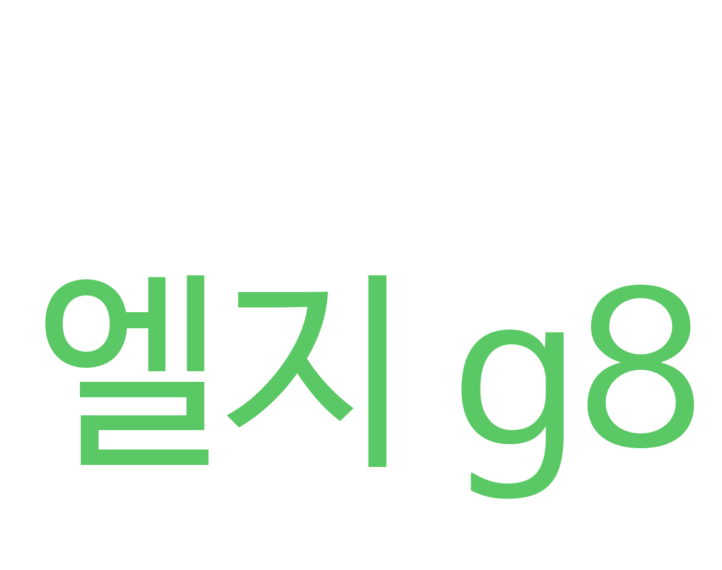

삼성 연관 키워드


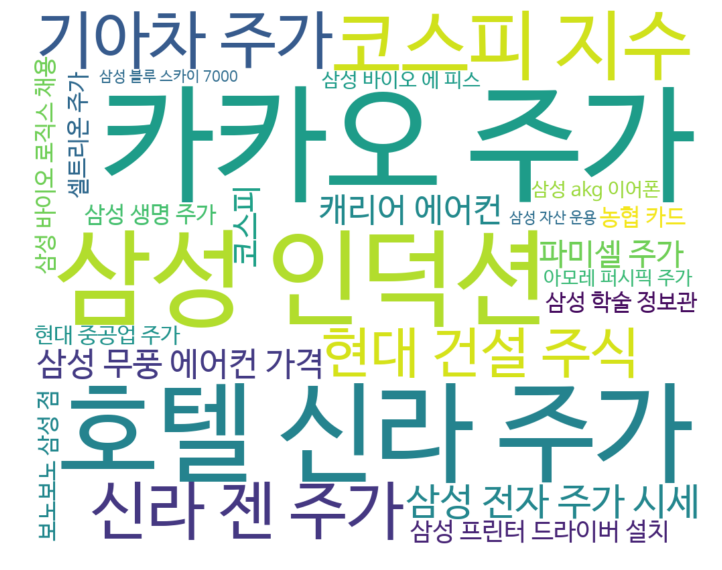

LG 연관 키워드


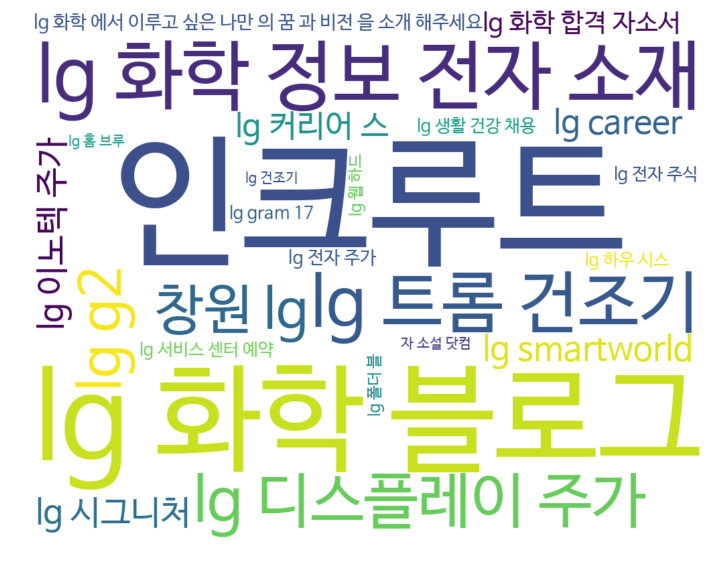

In [39]:
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud
from PIL import Image
%matplotlib inline
font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

for i in range(len(top5_related_value)):
    
    
    try:
        
        dictionary = dict(zip(top5_related_keyword[i], 
                          top5_related_value[i]))
        
        
        wordcloud = WordCloud(font_path = font_path,
                          width = 1000,
                          height = 800,
                          background_color='white')
    
        wordcloud = wordcloud.generate_from_frequencies(dictionary)

        plt.figure(figsize=(12,12))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        print('{} 연관 키워드'.format(top5_topic[i][0]))
        plt.show()
        
    except:
        
        pass